In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import xgboost as xgb
from scipy import stats

In [341]:
df =pd.read_csv('../../../data/preprocessed/feature_selection_by_dicision_tree_final_data_v3_30feature.csv')
X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']

In [342]:
df.columns.tolist()

['land_area',
 'near_Koh_Pich_in_km',
 'near_AEON_Mall_1_in_km',
 'near_Camko_City_in_km',
 'near_Boeng_Keng_Kang_1_in_km',
 'near_Wat_Phnom_in_km',
 'n_cafe_in_3km_to_5km',
 'n_gas_station_5km',
 'n_gas_station_in_2km_to_3km',
 'n_gas_station_in_3km_to_5km',
 'n_hospital_in_2km_to_3km',
 'n_hotel_in_1km',
 'n_hotel_in_1km_to_2km',
 'n_pre_school_in_3km_to_5km',
 'n_primary_school_in_2km_to_3km',
 'n_university_in_2km_to_3km',
 'nearest_resturant',
 'n_resturant_in_1km_to_2km',
 'n_resturant_in_2km_to_3km',
 'n_super_market_5km',
 'n_bank_5km',
 'nearest_atm',
 'n_atm_in_1km_to_2km',
 'n_atm_in_2km_to_3km',
 'n_atm_in_3km_to_5km',
 'h_id_price_mean',
 'h_id_price_max',
 'h_id_price_median',
 'h_id_price_min',
 'address_line_2_Bak Kaeng',
 'address_line_2_Boeng Kak Ti Muoy',
 'address_line_2_Boeng Kak Ti Pir',
 'address_line_2_Boeng Keng Kang Ti Bei',
 'address_line_2_Boeng Keng Kang Ti Muoy',
 'address_line_2_Boeng Keng Kang Ti Pir',
 'address_line_2_Boeng Proluet',
 'address_line_2_Bo

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [344]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [345]:
best_xgb = XGBRegressor(
    objective='reg:absoluteerror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    # Optimized parameters for MAPE reduction
    n_estimators=150,          # Increased capacity
    learning_rate=0.03,         # Moderate learning rate
    max_depth=5,                # Slightly deeper trees
    # Balanced regularization
    subsample=0.7,              # More data usage
    colsample_bytree=0.8,       # More features
    gamma=0.3,                  # Reduced gamma
    reg_alpha=1,                # Reduced L1
    reg_lambda=1,               # Reduced L2
    min_child_weight=5,         # More flexible leaves
    # MAPE-specific optimization
    max_delta_step=5            # Helps with MAPE reduction
)


In [346]:
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

In [347]:
best_xgb.fit(
    X_train_main, y_train_main,
    eval_set=[(X_val, y_val)],
    verbose=50
)

[0]	validation_0-mae:1503.29847


[50]	validation_0-mae:480.56638
[100]	validation_0-mae:277.86578
[149]	validation_0-mae:224.28605


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.3, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=5, max_depth=5,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=-1, num_parallel_tree=None, ...)

In [348]:
y_pred_train = best_xgb.predict(X_train_scaled)
y_pred_test = best_xgb.predict(X_test_scaled)

In [349]:
def print_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    
    print(f"\n{set_name} Metrics:")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    if set_name == "Test":
        print(f"Avg Price: {y_true.mean():.2f}")
    return mae

In [350]:
train_mae = print_metrics(y_train, y_pred_train, "Train")
test_mae = print_metrics(y_test, y_pred_test, "Test")


Train Metrics:
R²: 0.9560
MAE: 230.30
MAPE: 22.01%

Test Metrics:
R²: 0.9564
MAE: 236.37
MAPE: 21.54%
Avg Price: 2074.79


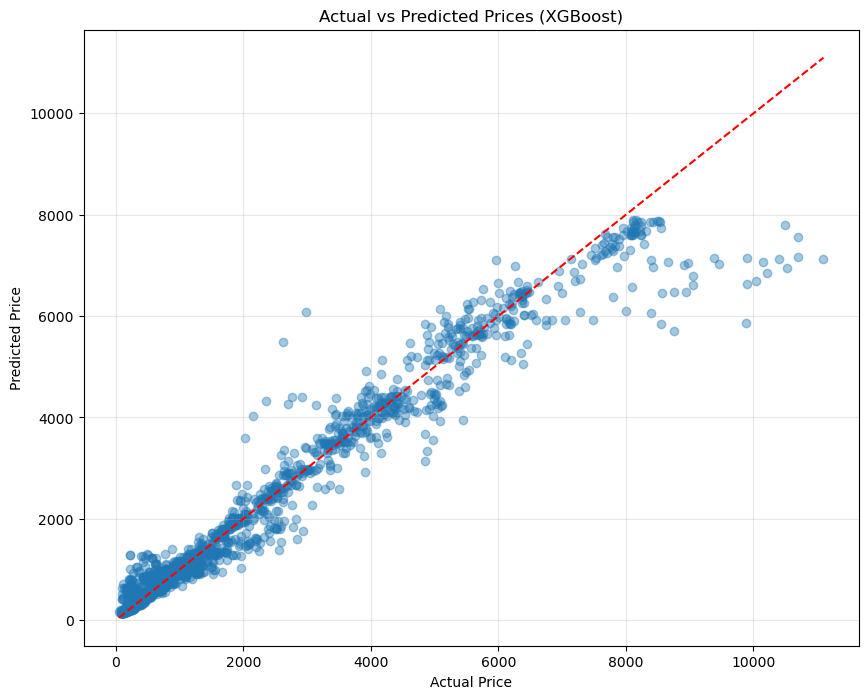

In [351]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (XGBoost)")
plt.grid(alpha=0.3)
plt.savefig("xgboost_actual_vs_predicted.png", dpi=300)
plt.show()

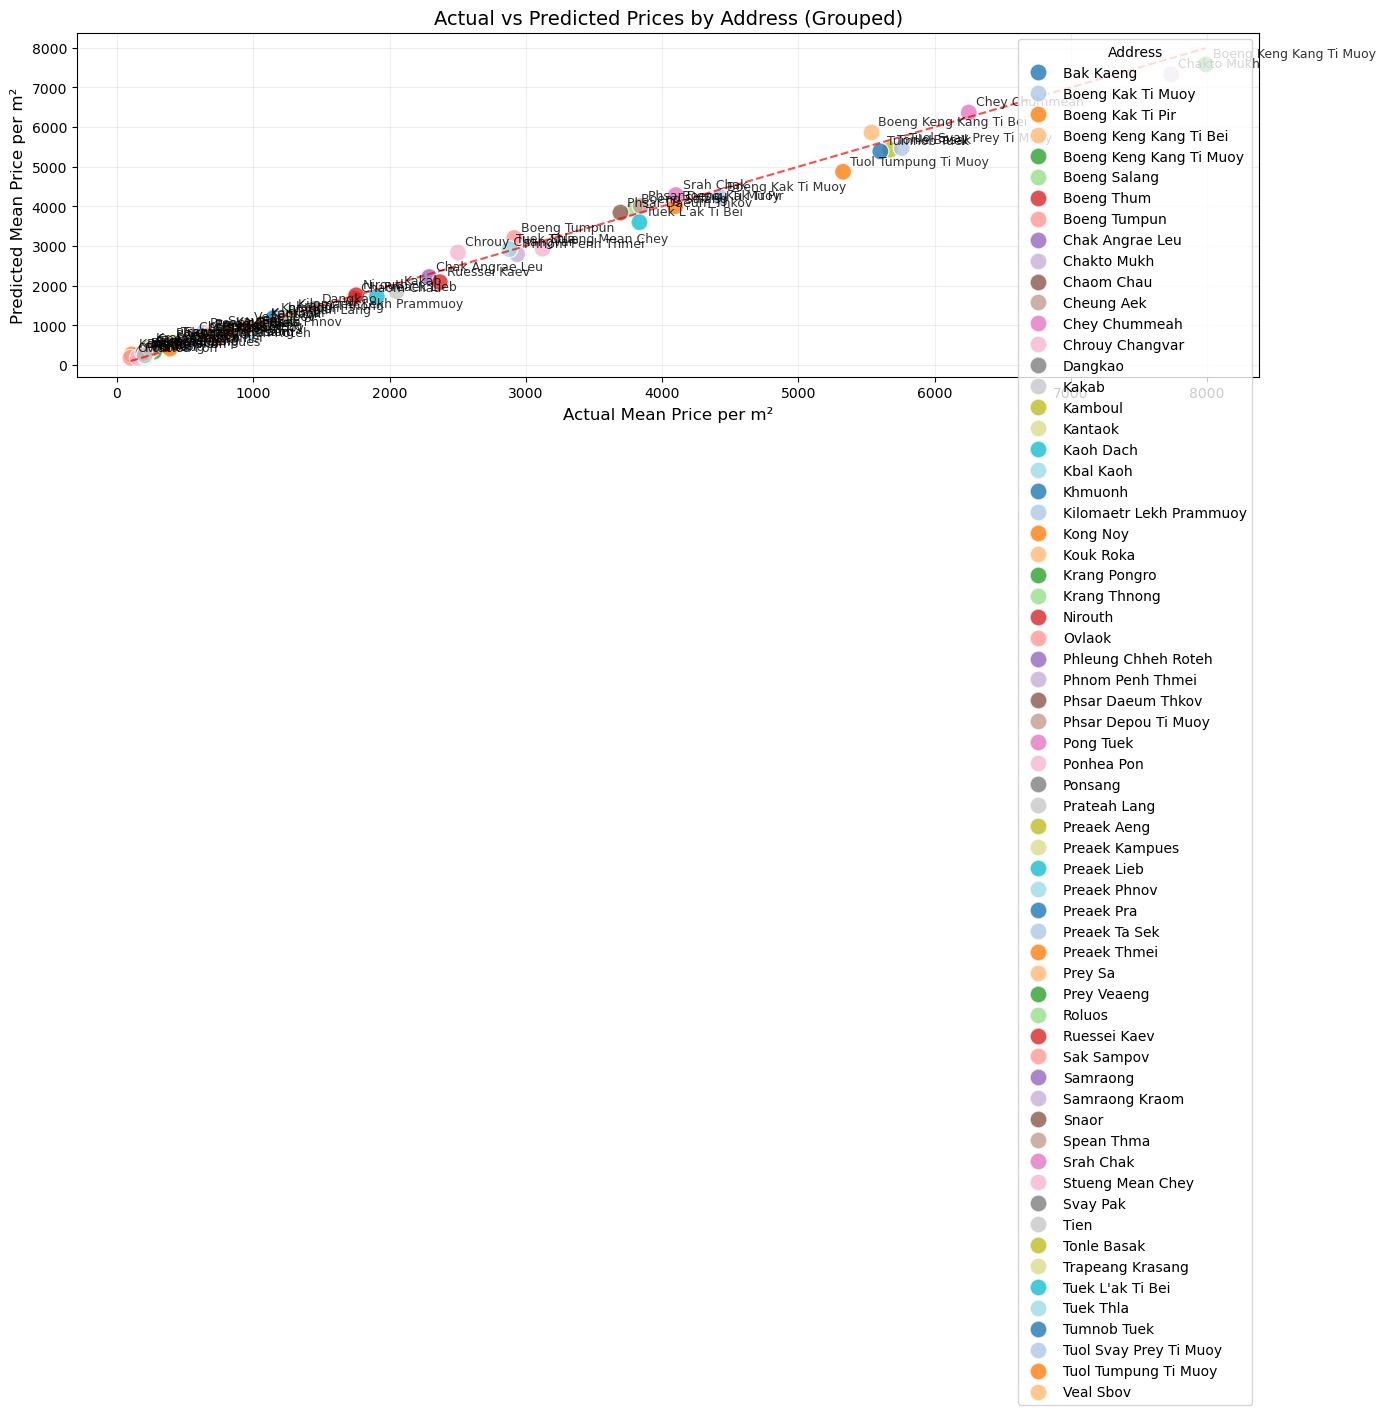

C:\Users\User\AppData\Local\Temp\ipykernel_2104\897449002.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  address_group_filtered['Error'] = address_group_filtered['Predicted'] - address_group_filtered['Actual']
C:\Users\User\AppData\Local\Temp\ipykernel_2104\897449002.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  address_group_filtered['AbsError'] = np.abs(address_group_filtered['Error'])
C:\Users\User\AppData\Local\Temp\ipykernel_2104\897449002.py:82: FutureWarning: 

Passing `palette` without 

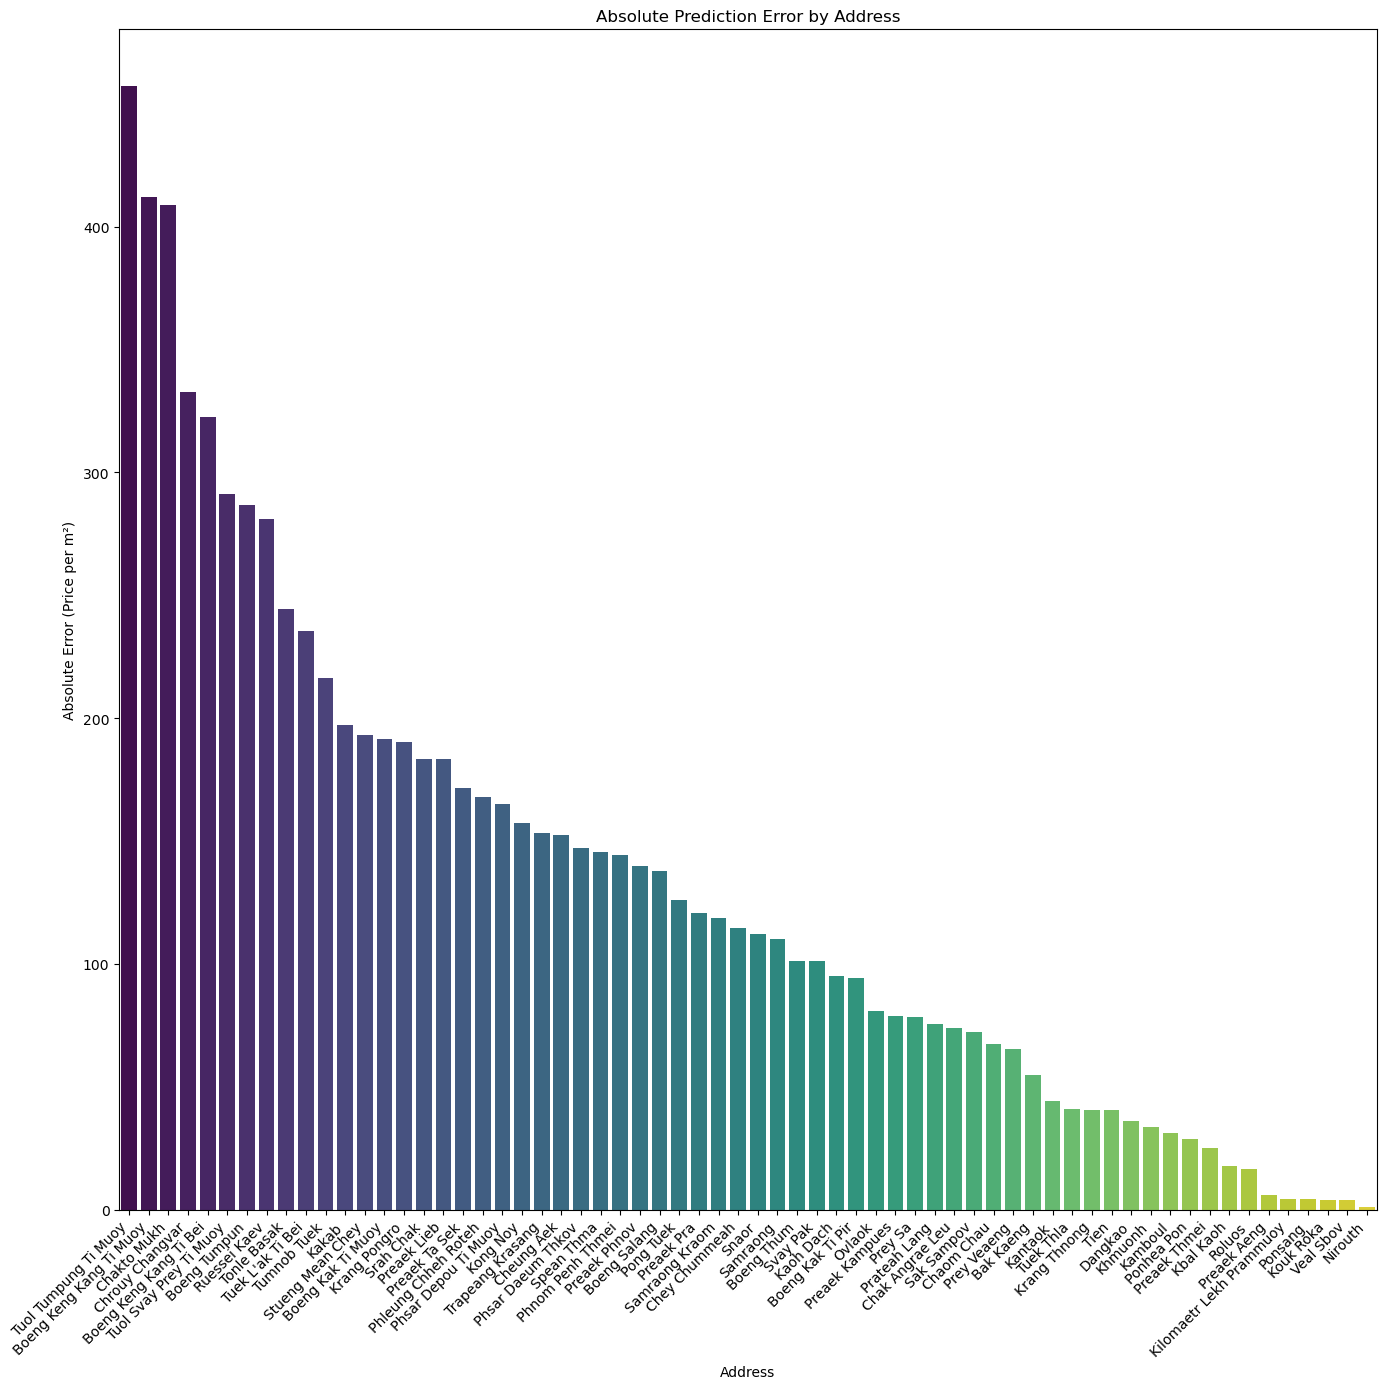

In [352]:
# First, let's identify all address columns
address_cols = [col for col in X.columns if col.startswith('address_line_2_')]

# Create a reverse mapping for one-hot encoded addresses
address_mapping = {}
for col in address_cols:
    address_name = col.replace('address_line_2_', '')
    address_mapping[col] = address_name

# Create a DataFrame for test results including addresses
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test
}, index=X_test.index)

# Add address information by finding which address column has value 1
test_results['Address'] = "Other"
for col, address_name in address_mapping.items():
    mask = X_test[col] == 1
    test_results.loc[mask, 'Address'] = address_name

# Now group by address and calculate mean values
address_group = test_results.groupby('Address').agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index()

# Filter for addresses with significant representation
min_samples = 10  # Minimum samples per address to include
address_counts = test_results['Address'].value_counts()
significant_addresses = address_counts[address_counts >= min_samples].index.tolist()
if 'Other' in significant_addresses:
    significant_addresses.remove('Other')  # Remove "Other" category

address_group_filtered = address_group[address_group['Address'].isin(significant_addresses)]

# Create the plot
plt.figure(figsize=(14, 10))
ax = sns.scatterplot(
    data=address_group_filtered,
    x='Actual',
    y='Predicted',
    hue='Address',
    s=150,  # Size of points
    alpha=0.8,
    palette='tab20'  # Color palette with many distinct colors
)

# Add labels to points
for i, row in address_group_filtered.iterrows():
    plt.annotate(
        row['Address'], 
        (row['Actual'], row['Predicted']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        alpha=0.8
    )

# Add diagonal line
max_val = max(address_group_filtered[['Actual', 'Predicted']].max())
min_val = min(address_group_filtered[['Actual', 'Predicted']].min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)

# Add labels and title
plt.xlabel("Actual Mean Price per m²", fontsize=12)
plt.ylabel("Predicted Mean Price per m²", fontsize=12)
plt.title("Actual vs Predicted Prices by Address (Grouped)", fontsize=14)
plt.grid(alpha=0.2)

# Add legend (optional, might be crowded)
# plt.legend(title='Address', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Additional plot: Error by address
address_group_filtered['Error'] = address_group_filtered['Predicted'] - address_group_filtered['Actual']
address_group_filtered['AbsError'] = np.abs(address_group_filtered['Error'])

plt.figure(figsize=(14, 14))
sns.barplot(
    data=address_group_filtered.sort_values('AbsError', ascending=False),
    x='Address',
    y='AbsError',
    palette='viridis'
)
plt.xticks(rotation=45, ha='right')
plt.title('Absolute Prediction Error by Address')
plt.ylabel('Absolute Error (Price per m²)')
plt.xlabel('Address')
plt.tight_layout()
plt.show()